In [0]:
# from google.colab import auth
# auth.authenticate_user()

# from google.colab import drive
# drive.mount('/content/gdrive')

import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2



#r은 단순히 파일을 참조한다는 뜻
train_data = h5py.File('gdrive/My Drive/smile_data/train_happy.h5', 'r')
test_data = h5py.File('gdrive/My Drive/smile_data/test_happy.h5', 'r')

x_train = np.array(train_data['train_set_x'][:])  #이미지
y_train = np.array(train_data['train_set_y'][:])  #1 혹은 0 (웃으면 1, 안 웃으면 0)

x_test = np.array(test_data['test_set_x'][:])
y_test = np.array(test_data['test_set_y'][:])

y_train = y_train.reshape((y_train.shape[0], 1))  #(600,1)로 바꿔줌
y_test = y_test.reshape((y_test.shape[0], 1))     #(150,1)로 바꿔줌

np.save('dataset/x_train_color.npy', x_train)
np.save('dataset/x_test_color.npy', x_test)

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# 데이터 확인
# plt.subplot(2,2,1)
# plt.title(y_train[0])
# plt.imshow(x_train[0])
# plt.subplot(2,2,2)
# plt.title(y_train[1])
# plt.imshow(x_train[1])
# plt.subplot(2,2,3)
# plt.title(y_test[0])
# plt.imshow(x_test[0])
# plt.subplot(2,2,4)
# plt.title(y_test[1])
# plt.imshow(x_test[1])

# x_train 과 x_test 에 들어있는 이미지를 gray scale 로 변환
x_result = []
for x in x_train:
  img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  x_result.append(img)

x_result = np.array(x_result)
np.save('dataset/x_train.npy', x_result)

x_result = []
for x in x_test:
  img = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
  x_result.append(img)

x_result = np.array(x_result)
np.save('dataset/x_test.npy', x_result)

# y데이터도 저장
np.save('dataset/y_train.npy', y_train)
np.save('dataset/y_test.npy', y_test)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4194368   
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
__________________________

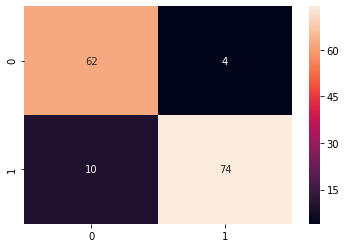

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Activation, LeakyReLU, Flatten, Dropout
from keras.models import Model, Sequential, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

x_train = np.load('dataset/x_train.npy')
y_train = np.load('dataset/y_train.npy')
x_test = np.load('dataset/x_test.npy')
y_test = np.load('dataset/y_test.npy')

# print(x_train.shape, y_train.shape)
# print(x_test.shape, y_test.shape)

# plt.subplot(1,2,1)
# plt.title(y_train[0])
# plt.imshow(x_train[0], cmap = 'gray')
# plt.subplot(1,2,2)
# plt.title(y_train[1])
# plt.imshow(x_test[0], cmap = 'gray')

x_train = x_train.reshape((-1, 64, 64, 1))
x_test = x_test.reshape((-1, 64, 64, 1))

train_datagen = ImageDataGenerator( # 데이터 증강 augmentation
    samplewise_center = True,       #각 이미지의 평균을 0으로 만듬
    samplewise_std_normalization = True,  # 사진의 픽셀들을 사진 전체의 표준편차로 나눔 
    #각 사진의 밝기나 스케일이 다르더라도 학습이 쉽도록 도움을 줌
    
    brightness_range = [0.5, 1.5],  # 원래 밝기를 1로 치고 50퍼센트 어둡게 50퍼센트 밝게
    zoom_range = [0.8, 1.1],        # 크기를 0.8에서 1.1까지 임의로 늘리거나 줄임
    rotation_range =15.,            #-15도부터 15도까지 이미지 돌림
    channel_shift_range = 25,       # channel_shift를 25까지
    horizontal_flip = True          # 좌우로 flip
)

test_datagen = ImageDataGenerator(
    samplewise_center = True,
    samplewise_std_normalization = True,
)

#flow 메서드는 x 데이터와 y 데이터를 batch 단위로 생성할 수 있도록 만드는 것
train_batch_gen = train_datagen.flow(x_train, y_train, batch_size = 16, shuffle = True)
test_batch_gen = test_datagen.flow(x_test, y_test, batch_size = 16, shuffle = False)

#딥러닝 모델 생성
inputs = Input(shape = (64, 64, 1)) # 그레이 스케일이니까 channel 1
net = Conv2D(filters = 64, kernel_size = 3, strides = 2, padding = 'same')(inputs)
net = LeakyReLU()(net)

net = Flatten()(net) # 3차원의 배열을 일자로 펴줌

net = Dense(units = 64)(net)  #64개짜리 Dense 레이어 사용
net = Activation('relu')(net)

net = Dense(units = 1)(net)   # output은 1
outputs = Activation('sigmoid')(net)

model = Model(inputs = inputs, outputs = outputs) #Model 클래스 이용해 실제적인 keras 모델 만들어줌
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])  #acc은 accuracy

model.summary() #모델 모양 조회

#모델 학습
model.fit_generator(
    train_batch_gen, 
    epochs = 20,
    validation_data = test_batch_gen,
    callbacks = [ #한 에폭이 끝날 때 마다 실행
                 ModelCheckpoint('models/happy.h5', monitor = 'val_acc', save_best_only = True, mode = 'max', verbose = 1), #모델 하나의 에폭이 끝날 때마다 저장
                 #validation 의 accuacy를 체크해서 가장 좋은 것만 저장. accuracy가 가장 큰 것만 저장. 저장할 때 프린트
                 ReduceLROnPlateau(monitor = 'val_acc', factor = 0.2, patience = 5, verbose = 1, mode = 'auto', min_lr = 1e-05) #running rate 조정
                 #validation 의 accuacy를 체크. validation의 accuracy가 높아지지 않아도 5번을 참고 그 이후에도 학습이 안 되면 running rate에 0.1을 곱함
                 #최소 running rate는 1e-05까지 
    ] 
)

#학습된 모델 검증
x_test_input = x_test.copy().astype(np.float64)

#normalization 수동으로 하는 것
x_test_input -= np.mean(x_test, keepdims=True)  
x_test_input /= (np.std(x_test, keepdims=True) + 1e-6)

y_pred = model.predict(x_test_input)  # 예측(150개의 아웃풋 생성)

y_pred_logical = (y_pred > 0.5).astype(np.int)  #웃은 것은 True(1) 안 웃은 것은 False(0)으로 저장

print('test acc : %s' % accuracy_score(y_test, y_pred_logical)) #accuracy_score를 이용해 y_test, y_pred_logical을 비교

cm = confusion_matrix(y_test, y_pred_logical) #confusion_matrix는 y_test, y_pred_logical을 비교
sns.heatmap(cm, annot=True) #confusion_matrix 실제 그리기
# 세로 축 : 예측값, 가로축 : 실제 값